In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

warnings.filterwarnings('ignore')
df = pd.read_csv("MakroDashboard\data\ML data\Monthly_wide.csv")  # Make sure it has 15 columns
#df = pd.read_csv("MakroDashboard\data\ML data\Quarterly_wide2.csv") 

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Ricks\AppData\Local\Temp\ipykernel_11396\2065670918.py:21: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("MakroDashboard\data\ML data\Monthly_wide.csv")  # Make sure it has 15 columns


## Processing the data

In [2]:
# Step 1: Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time')

# Step 2: Select numeric columns
df_numeric = df.select_dtypes(include=["number"])

# Step 3: Add time column back
df_final = pd.concat([df_numeric, df[['time']]], axis=1)

# Step 4: Fill NaNs
df_final = df_final.dropna()

# Step 5: Identify target columns (Finland columns)
finland_columns = [col for col in df_final.columns if 'Finland' in col]

In [3]:
# Step 6: Create lagged features for all numeric columns (excluding 'time')
def create_lag_features(df, columns, lags=10):
    for col in columns:
        for lag in range(1, lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Create lag features
lagged_df = create_lag_features(df_final.copy(), df_numeric.columns, lags=10)

# Step 7: Create future target (1 step ahead)
horizon = 1  # You can change this to 3 for 3-month ahead prediction
for col in finland_columns:
    lagged_df[f'{col}_target'] = lagged_df[col].shift(-horizon)

# Step 8: Drop original (non-lagged) features + rows with NaN
lagged_df = lagged_df.drop(columns=finland_columns + ['time'])  # keep only lags + targets
lagged_df = lagged_df.dropna()

# Step 9: Train/test split
train_size = int(len(lagged_df) * 0.8)
train_data = lagged_df.iloc[:train_size]
test_data = lagged_df.iloc[train_size:]

# Step 10: Features (X) and Targets (y)
target_columns = [col for col in lagged_df.columns if col.endswith('_target')]

X_train = train_data.drop(columns=target_columns)
y_train = train_data[target_columns]

X_test = test_data.drop(columns=target_columns)
y_test = test_data[target_columns]



## The modeling

In [4]:
# Select a model 
selected_model = 'xgb'  # 'rf' or 'xgb'

# Define base model and param grid
if selected_model == 'xgb':
    base_model_class = XGBRegressor
    param_grid = {
        'model__n_estimators': [50, 100, 200, 250],
        'model__max_depth': [1.5, 2, 3, 4],
        'model__learning_rate': [ 0.01, 0.05, 0.1, 0.15]
    }
elif selected_model == 'rf':
    base_model_class = RandomForestRegressor
    param_grid = {
        'model__n_estimators': [50, 100, 200, 250]
    }
elif selected_model == 'Lasso':
    base_model_class = Lasso
    param_grid = {
        'model__alpha': [0.001, 0.01, 0.1, 0.5, 1.0]
    }
elif selected_model == 'Ridge':
    base_model_class = Ridge
    param_grid = {
        'model__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2, 2,5, 3, 4]
    }
else:
    raise ValueError("Choose either 'xgb', 'rf', 'Lasso' or 'Ridge'.")

# === LOOP OVER TARGETS ===
all_best_models = []
all_results = []

for i, target in enumerate(y_train.columns):
    print(f" Tuning model for target: {target}")

    y_target = y_train[target]

    model = base_model_class()
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=6)
    grid.fit(X_train, y_target)

    best_model = grid.best_estimator_
    all_best_models.append(best_model)

    all_results.append({
        'target': target,
        'best_params': grid.best_params_,
        'best_mse': -grid.best_score_
    })

# Create MultiOutputRegressor from the tuned models
multi_model = MultiOutputRegressor(estimator=None)
multi_model.estimators_ = [model.named_steps['model'] for model in all_best_models]
multi_model.estimators_ = all_best_models

# Store results as DataFrame
results_df = pd.DataFrame(all_results)

# Print the full results with expanded columns
print("\n📊 Full tuning results per target:\n")
pd.set_option('display.max_colwidth', None)  # Show full parameter dict
print(results_df.to_string(index=False))

 Tuning model for target: Infaltion CPI_Finland_target
 Tuning model for target: Change in energy price_Finland_target
 Tuning model for target: Change in food price_Finland_target
 Tuning model for target: Unemployment data_Finland_target

📊 Full tuning results per target:

                               target                                                                       best_params  best_mse
         Infaltion CPI_Finland_target {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200}  0.267443
Change in energy price_Finland_target  {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 50} 17.493367
  Change in food price_Finland_target {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200}  3.392592
     Unemployment data_Finland_target {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200}  0.787086


## Predictions 

In [7]:
n_steps = 1  # number of months ahead to forecast
future_forecasts = []

# Start with the most recent input
current_input = X_test.iloc[[-1]].copy()

# Get the feature names from X_train
feature_names = X_train.columns

# Loop through the steps to forecast
for step in range(n_steps):
    # Ensure the current_input contains the correct features
    current_input = current_input[feature_names]
    
    # Predict the next step
    prediction = multi_model.predict(current_input)[0]
    future_forecasts.append(prediction)

    # Shift lag features forward (lag3 -> lag2, lag2 -> lag1, lag1 -> prediction)
    new_input = current_input.copy()
    for i, col in enumerate(y_test.columns):
        try:
            # Shift lags: lag3 -> lag2, lag2 -> lag1
            for lag in range(3, 1, -1):
                new_input[f'{col}_lag{lag}'] = new_input.get(f'{col}_lag{lag-1}', np.nan)
            # Set lag1 to the current prediction for the variable
            new_input[f'{col}_lag1'] = prediction[i]
        except KeyError as e:
            print(f"Skipping column due to KeyError: {e}")

    # Update the input for the next step (if forecasting more than 1 step ahead)
    current_input = new_input.copy()

# Convert forecast list to DataFrame
future_forecast_df = pd.DataFrame(future_forecasts, columns=y_test.columns)

# Print the forecasted values for the next n_steps
print("Forecasts for the next", n_steps, "months:")
print(future_forecast_df)


Forecasts for the next 1 months:
   Infaltion CPI_Finland_target  Change in energy price_Finland_target  \
0                      1.394644                               3.657647   

   Change in food price_Finland_target  Unemployment data_Finland_target  
0                            -0.625245                          8.671118  


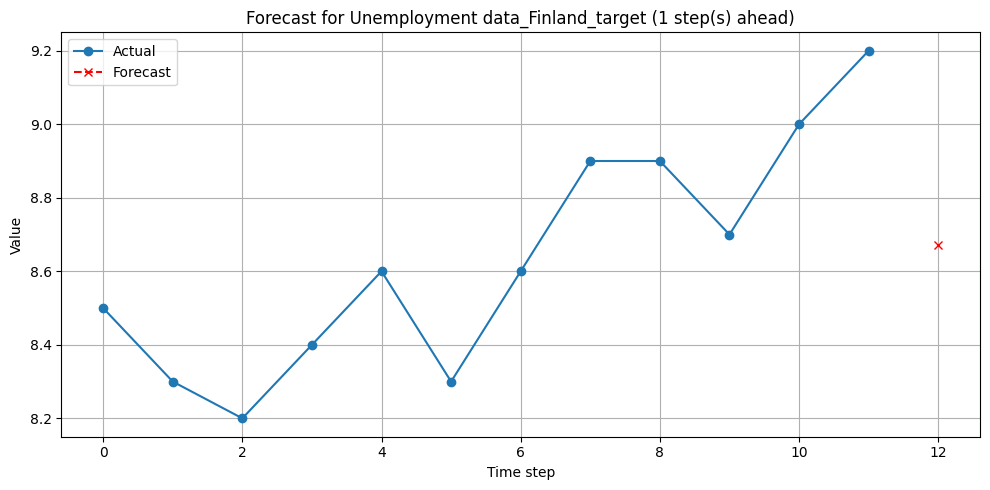

In [13]:
# Choose one variable to plot, e.g., the first one
target_column = y_test.columns[3]

# Combine last few actual values with the forecast
recent_actuals = y_test[target_column].tail(12).reset_index(drop=True)
forecast_values = pd.Series(future_forecast_df[target_column].values, index=range(len(recent_actuals), len(recent_actuals) + n_steps))

plt.figure(figsize=(10, 5))
plt.plot(recent_actuals, label="Actual", marker='o')
plt.plot(forecast_values, label="Forecast", marker='x', linestyle='--', color='red')
plt.title(f"Forecast for {target_column} ({n_steps} step(s) ahead)")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


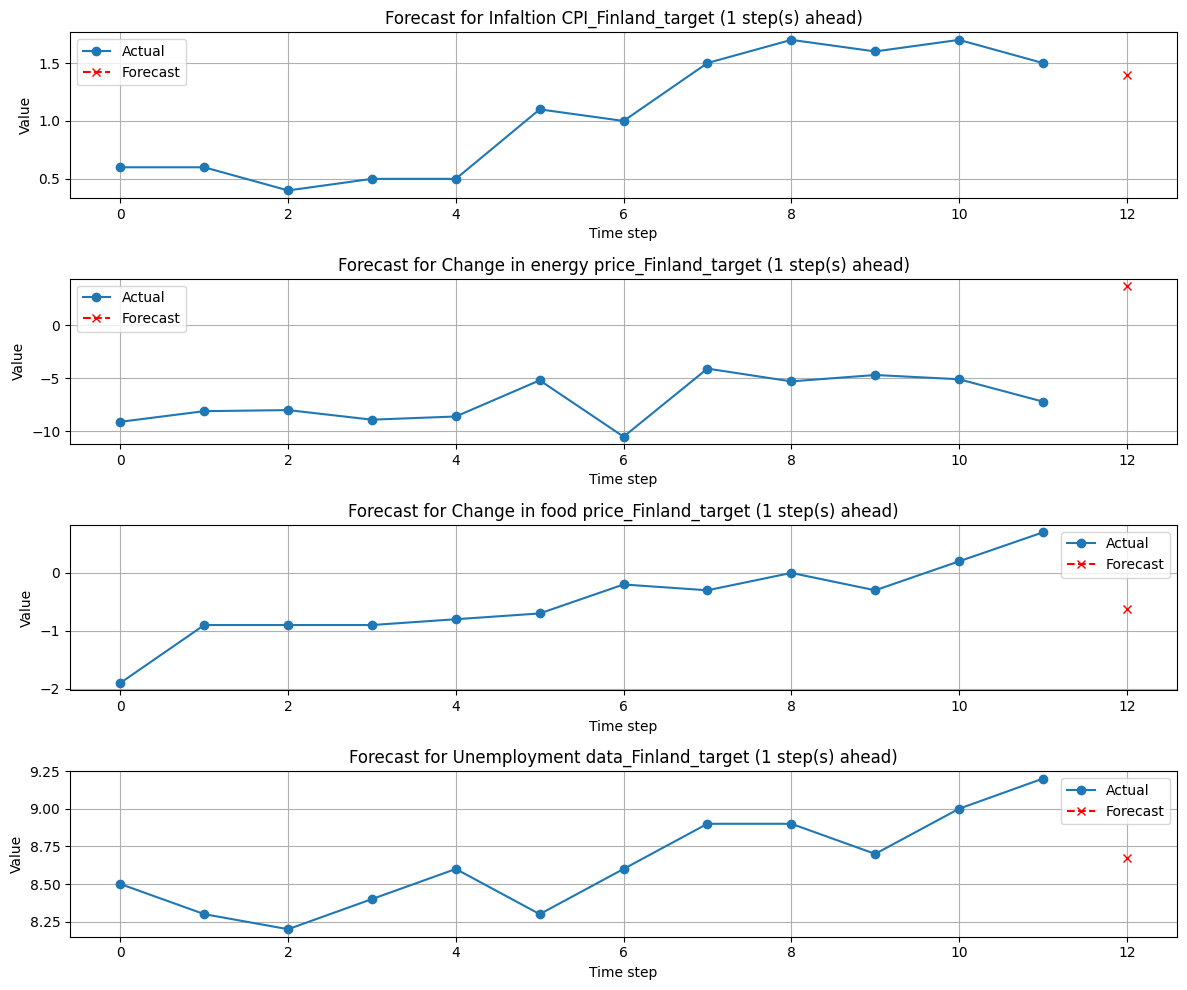

In [14]:
# Assuming future_forecast_df and y_test are already defined and n_steps is known
num_plots = 4  # number of subplots (columns 0 through 3)

plt.figure(figsize=(12, 10))  # adjust size as needed

for i in range(num_plots):
    target_column = y_test.columns[i]
    
    # Prepare data
    recent_actuals = y_test[target_column].tail(12).reset_index(drop=True)
    forecast_values = pd.Series(future_forecast_df[target_column].values, 
                                index=range(len(recent_actuals), len(recent_actuals) + n_steps))

    # Subplot i+1 (subplot index starts at 1)
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(recent_actuals, label="Actual", marker='o')
    plt.plot(forecast_values, label="Forecast", marker='x', linestyle='--', color='red')
    plt.title(f"Forecast for {target_column} ({n_steps} step(s) ahead)")
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
df_sorted = df.sort_values(by='time')
df_sorted2 = df_sorted[['time'] + finland_columns]
df_sorted2

,time,Current account_Finland,Direct investment_Finland,Employees Compensation_Finland,Totlat employment_Finland,Final consumption expenditure households_Finland,Change in GDP_Finland,Gross fixed capital formation_Finland,Government debt to gdp_Finland,Government expenditure_Finland,Change in Housing prices_Finland,Labour productivity_Finland,Net international investment_Finland,Nominal unit labour cost_Finland
80,1995-01-01,2.6,NaN,10896,1991.7,12073,-0.8,4266.0,NaN,5240.1,NaN,3.1,NaN,0.6
81,1995-04-01,3.7,NaN,11869,2092.5,12749,2.7,4811.5,NaN,5557.0,NaN,3.8,NaN,-0.2
82,1995-07-01,3.5,NaN,12326,2116.1,12374,-0.4,4988.1,NaN,5827.9,NaN,1.6,NaN,3.8
83,1995-10-01,5.9,NaN,12266,2034.5,13019,0.1,5749.4,NaN,5863.3,NaN,0.4,NaN,2.5
84,1996-01-01,1.6,NaN,11862,2012.9,12254,1.8,4682.2,NaN,5513.0,NaN,3.2,NaN,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023-10-01,1.8,191134.0,32080,2724.0,36110,-0.3,16378.0,77.3,18851.0,-1.0,-1.2,12.8,3.4
76,2024-01-01,-1.5,189895.0,32897,2698.2,34122,0.5,14191.0,78.1,17113.0,-1.3,-1.7,19.7,2.0
77,2024-04-01,-2.3,189522.0,33886,2801.7,36196,0.1,14551.0,80.1,18442.0,0.2,0.4,18.2,-0.2
78,2024-07-01,3.0,193770.0,33964,2799.8,36140,0.6,15004.0,81.5,17397.0,-0.7,1.3,21.0,-1.1


In [ ]:
# OLD but gold

In [12]:

xgb_model = XGBRegressor(
    n_estimators=25,
    max_depth=4,
    learning_rate=0.02,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1
)

random_f_model = RandomForestRegressor(
    n_estimators=100,
)



multi_model = MultiOutputRegressor(xgb_model)
multi_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.02, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=25, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [13]:
# Predict on test set
y_pred = multi_model.predict(X_test)

# Initialize lists for R² and MSE
r2_per_target = []
mse_per_target = []

# Loop through each target column
for i, target in enumerate(y_test.columns):
    y_true_col = y_test.iloc[:, i]
    y_pred_col = y_pred[:, i]

    r2 = r2_score(y_true_col, y_pred_col)
    mse = mean_squared_error(y_true_col, y_pred_col)

    r2_per_target.append(r2)
    mse_per_target.append(mse)

    print(f"Target: {target}")
    print(f"  R²: {r2:.4f}")
    print(f"  MSE: {mse:.4f}")
    print("-" * 30)

# Print average scores
print("📊 Average R² across all targets:", round(sum(r2_per_target) / len(r2_per_target), 4))
print("📉 Average MSE across all targets:", round(sum(mse_per_target) / len(mse_per_target), 4))

Target: Infaltion CPI_Finland_target
  R²: 0.1290
  MSE: 6.5339
------------------------------
Target: Change in energy price_Finland_target
  R²: 0.2102
  MSE: 174.6055
------------------------------
Target: Change in food price_Finland_target
  R²: 0.2689
  MSE: 23.1477
------------------------------
Target: Unemployment data_Finland_target
  R²: -0.5887
  MSE: 0.9585
------------------------------
📊 Average R² across all targets: 0.0049
📉 Average MSE across all targets: 51.3114
